# Toxicity compare
## This is a tool to compare the previously selected distilBERT model with a standard classifier in order to establish the efficacy of the model
George Cotea, 2024 

In [1]:
# Import pandas, json, random
import pandas as pd
import json
import random
from toxicityclassifier import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch


# Initialize tokenizer and model
model_name = "citizenlab/distilbert-base-multilingual-cased-toxicity"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Setup MPS device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Extracting 5000 samples using Proportional Stratified Sampling


In [2]:
def calculate_sample_sizes(file_paths, total_sample_size=5000):
    # Read each CSV file and calculate the number of messages
    message_counts = {stratum: len(pd.read_csv(file_path)) for stratum, file_path in file_paths.items()}
    
    # Total number of messages
    total_messages = sum(message_counts.values())
    
    # Proportions
    proportions = {stratum: count / total_messages for stratum, count in message_counts.items()}
    
    # Sample sizes for each stratum
    sample_sizes = {stratum: round(proportion * total_sample_size) for stratum, proportion in proportions.items()}
    
    return sample_sizes, message_counts

def stratified_sampling(file_paths, sample_sizes):
    # Read each CSV file and sample the required number of messages
    samples = pd.concat([
        pd.read_csv(file_paths[stratum]).sample(n=sample_size, random_state=None)  # Set random_state=None for true random sampling
        for stratum, sample_size in sample_sizes.items()
    ])
    
    return samples

# File paths for each stratum
file_paths = {
    'A0': '/Users/george/Desktop/Uni/2023-2024/Thesis/Final Thesis Collection/testCSV/nomoderation2.csv',
    'A1': '/Users/george/Desktop/Uni/2023-2024/Thesis/Final Thesis Collection/testCSV/basicmoderation.csv',
    'A2': '/Users/george/Desktop/Uni/2023-2024/Thesis/Final Thesis Collection/testCSV/advancedmoderation.csv',
    'A3': '/Users/george/Desktop/Uni/2023-2024/Thesis/Final Thesis Collection/testCSV/selection.csv'
}

# Calculate sample sizes based on the actual number of messages in each CSV file
sample_sizes, message_counts = calculate_sample_sizes(file_paths)

# Perform stratified sampling
samples = stratified_sampling(file_paths, sample_sizes)

# Save the samples to a new CSV file 
output_file_path = '/Users/george/Desktop/Uni/2023-2024/Thesis/Final Thesis Collection/stratifiedSampling/stratified_samples.csv'
samples.to_csv(output_file_path, index=False)

samples.head(1000)


,id,message
24306,29269,"Not as much. \nIf you guess correctly, you are..."
11496,60326,Do your research about it.
5546,70479,So make sure you don't miss out guys load up y...
29983,15829,Gm
19916,34858,This is serious
...,...,...
396695,483489,actually
174247,749932,Wait i till try to get you RD
791062,27250,Hold on I'm stuck in the A slot
732749,93826,kernel panic


### Basic Toxicity Keyword Classifier

In [3]:
# Load the toxic keywords set
def load_toxic_keywords():
    return {
        'abuse', 'abusive', 'annoying', 'assassin', 'assassinate',
        'attack', 'bad', 'banish', 'bastard', 'betray', 'bitch',
        'blame', 'break', 'broken', 'bully', 'cancel', 'cheat',
        'cunt', 'corrupt', 'crap', 'crazy', 'creep', 'criminal',
        'crude', 'cursed', 'damn', 'damned', 'dead', 'dangerous',
        'deceive', 'defeat', 'defect', 'destroy', 'distructed',
        'detest', 'devil', 'die', 'disgust', 'disgusting', 'dishonest',
        'distrust', 'dumb', 'eliminate', 'evil', 'fail', 'fake',
        'fuck','fucked', 'fool', 'fraud', 'furious', 'garbage', 'gross',
        'harm', 'hate', 'horrible', 'hostile', 'idiot', 'ignorant',
        'ignore', 'ill', 'immoral', 'impose', 'inept', 'inferior',
        'insane', 'insult', 'jealous', 'jerk', 'kill', 'liar',
        'loser', 'lousy', 'mad', 'malicious', 'manipulate',
        'mislead', 'monster', 'nasty', 'naughty', 'negative', 'nonsense',
        'obnoxious', 'oppress', 'pathetic', 'pervert', 'petty', 'perverted',
        'poison', 'poor', 'prejudice', 'pretend', 'prick',
        'racist', 'rape', 'ridiculous', 'rotten', 'rude', 'ruin', 'retard', 'retarded'
        'savage', 'scam', 'scare', 'scum', 'selfish', 'shit',
        'shut up', 'sick', 'shag', 'sinister', 'sucker', 'sod',
        'swine', 'stupid', 'suck', 'suffer', 'terrible', 'terror',
        'trash', 'trick', 'ugly', 'unfair', 'unhappy', 'unjust',
        'uneducated', 'useless', 'vain', 'vicious', 'vile', 'violate',
        'violent', 'waste', 'wicked', 'worthless', 'wrong', 'yuck'
    }

# Function to determine if a text is toxic
def is_toxic(text):
    toxic_keywords = load_toxic_keywords()
    words = set(text.lower().split())
    return bool(words.intersection(toxic_keywords))

##### Applying the classifiers for the sampled dataset

In [4]:
# DistilBERT implementation 
# Adjusted functions for manual inference
def classify_text(text, tokenizer, model, device, threshold=2/3):
    # Tokenization
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # Model inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = softmax(outputs.logits, dim=1)

    # Handling the output
    predictions = predictions.cpu().numpy() # Move to CPU and transform to numpy array
    toxic_scores = predictions[:, 0]  
    
    # Determine classification based on threshold
    classification = 'toxic' if toxic_scores.mean() >= threshold else 'not_toxic'
    score = toxic_scores.mean()
    
    return classification, score

# Apply classification across DataFrame with progress bar
from tqdm.auto import tqdm
tqdm.pandas(desc="Classifying messages")

# Ensure all messages are strings
samples['message'] = samples['message'].astype(str)

# Apply the classification function with progress_apply
results = samples['message'].progress_apply(lambda x: classify_text(x, tokenizer, model, device))
samples['classification'], samples['score'] = zip(*results)

Classifying messages:   0%|          | 0/5000 [00:00<?, ?it/s]

Keyword Toxicity Classifier

In [5]:
# Apply the classic function to each row in the DataFrame
samples['keyword_toxicity'] = samples['message'].apply(is_toxic)

In [6]:
# Save the results to a csv file
samples.to_csv('/Users/george/Desktop/Uni/2023-2024/Thesis/Final Thesis Collection/stratifiedSampling/samples_classified.csv')

### Comparing the two classifiers and determining the Dissagreement Matrix

[[4440  225]
 [ 175  160]]


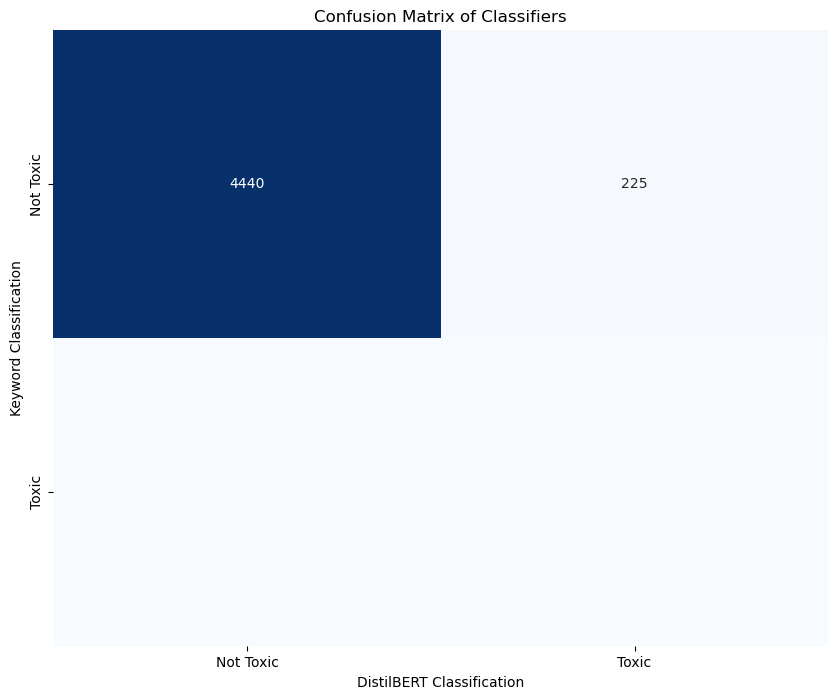

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

samples_classified = pd.read_csv('/Users/george/Desktop/Uni/2023-2024/Thesis/Final Thesis Collection/stratifiedSampling/samples_classified.csv')

# Prepare the true labels and predicted labels
y_true = samples_classified['keyword_toxicity'].apply(lambda x: 1 if x else 0)  # Convert boolean to 0 and 1
y_pred = samples_classified['classification'].apply(lambda x: 1 if x == 'toxic' else 0)  # Convert 'toxic'/'not_toxic' to 1/0

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
# Plot the confusion matrix with improved formatting
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
plt.xlabel('DistilBERT Classification')
plt.ylabel('Keyword Classification')
plt.title('Confusion Matrix of Classifiers')

plt.show()

In [16]:
# Printing the count and ratio of disagreements
# print(f"Disagreement count (DistilBERT toxic, Keyword non-toxic): {disagreement_distilBERT_toxic_keyword_non_toxic}")
# print(f"Disagreement count (DistilBERT non-toxic, Keyword toxic): {disagreement_distilBERT_non_toxic_keyword_toxic}")
# print(f"Disagreement ratio (DistilBERT toxic, Keyword non-toxic): {disagreement_ratio_distilBERT_toxic_keyword_non_toxic}")
# print(f"Disagreement ratio (DistilBERT non-toxic, Keyword toxic): {disagreement_ratio_distilBERT_non_toxic_keyword_toxic}")

Disagreement count (DistilBERT toxic, Keyword non-toxic): 225
Disagreement count (DistilBERT non-toxic, Keyword toxic): 175
Disagreement ratio (DistilBERT toxic, Keyword non-toxic): 0.5844155844155844
Disagreement ratio (DistilBERT non-toxic, Keyword toxic): 0.03791982665222102
